# AI & DL

## Лабораторная работа №4

### Выполнил: Инютин М. А.
### Группа: М8О-407Б-19

Подключаю необходимые библиотеки

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()

### Загрузка [датасета](https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset)

В нём 62 класса - 26 латинских букв в строчном и прописном варианте, то есть 52, и 10 цифр. В каждом классе по 55 изображений, 44 для тренировки, 11 для валидации (соотношение 80/20). Разделение на выборке делает скрипт `process_eng.sh` в папке `data`

Для тестовой выборки производится нормализация, а для обучающей ещё и аугментация

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

here = !pwd
data_dir = here[0] + '/../data/eng/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Доступна ли видеокарта?

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Функция для визуализации изображений, пример входных данных

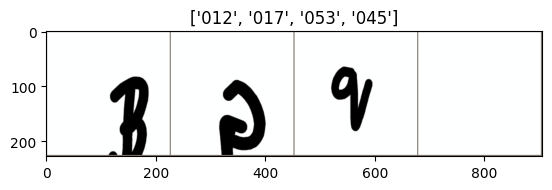

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Берём первый батч данных
inputs, classes = next(iter(dataloaders['train']))

# Создание сетки
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Функция для тренировки модели

На каждой эпохе прогоняем на всех данных, сохраняем модель, чтобы потом выбрать наилучшую версию

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # На каждой эпохе вычисляем метрики для обучающей и тестовой выборки
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Изменяем режим модели в зависимости от того, тренируем или валидируем
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Проходим по всем батчам данных
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Если обучаем, то распространяем ошибку на веса
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Считаем loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Копируем модель для выбора лучшей
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Печатаем суммарное время и счёт лучшей модель
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Загружаем лучшую модель
    model.load_state_dict(best_model_wts)
    return model

### Визуализация результатов обучения

Отображаем несколько изображений и предсказанное значение

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # Выключаем вычисление градиента
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Построение модели

Загружаем `resnset18` и очищаем последний слой, так как будем учить на своих классах

In [7]:
model_ft = models.resnet18(weights="DEFAULT")
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Учим параметры на всех слоях
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Уменьшаем LR каждые 7 эпох для лучшего результата
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Обучение модели и визуализация результата

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.3366 Acc: 0.1749
val Loss: 1.5541 Acc: 0.5572

Epoch 1/24
----------
train Loss: 2.1359 Acc: 0.4216
val Loss: 1.1565 Acc: 0.6569

Epoch 2/24
----------
train Loss: 1.7243 Acc: 0.5282
val Loss: 0.8789 Acc: 0.7375

Epoch 3/24
----------
train Loss: 1.5913 Acc: 0.5532
val Loss: 0.7566 Acc: 0.7859

Epoch 4/24
----------
train Loss: 1.5172 Acc: 0.5902
val Loss: 0.8350 Acc: 0.7551

Epoch 5/24
----------
train Loss: 1.5447 Acc: 0.5828
val Loss: 0.7982 Acc: 0.7742

Epoch 6/24
----------
train Loss: 1.4137 Acc: 0.6129
val Loss: 0.8484 Acc: 0.7786

Epoch 7/24
----------
train Loss: 1.1615 Acc: 0.6833
val Loss: 0.6048 Acc: 0.8182

Epoch 8/24
----------
train Loss: 1.1361 Acc: 0.6895
val Loss: 0.5681 Acc: 0.8299

Epoch 9/24
----------
train Loss: 1.0798 Acc: 0.7012
val Loss: 0.5783 Acc: 0.8328

Epoch 10/24
----------
train Loss: 1.0416 Acc: 0.7126
val Loss: 0.5541 Acc: 0.8284

Epoch 11/24
----------
train Loss: 1.0748 Acc: 0.7064
val Loss: 0.5381 Acc: 0.8182

Ep

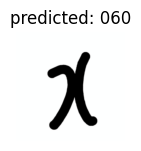

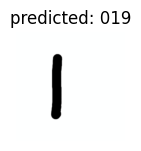

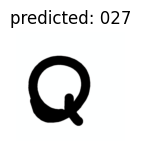

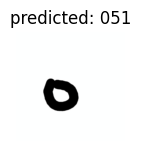

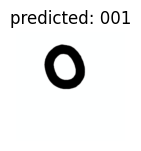

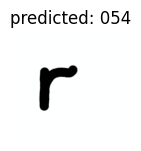

In [9]:
visualize_model(model_ft)

### Построение модели

Будем обучать сеть только на последних слоях, замораживая свёрточные слои

In [10]:
model_conv = torchvision.models.resnet18(weights="DEFAULT")
# Заморозка слоёв
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Учим только параметры последних слоёв
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Уменьшаем LR каждые 7 эпох для лучшего результата
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Обучение модели и визуализация результата

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.9375 Acc: 0.0627
val Loss: 2.8505 Acc: 0.2727

Epoch 1/24
----------
train Loss: 3.3330 Acc: 0.1771
val Loss: 2.1406 Acc: 0.4677

Epoch 2/24
----------
train Loss: 3.0283 Acc: 0.2368
val Loss: 1.9926 Acc: 0.4721

Epoch 3/24
----------
train Loss: 2.8161 Acc: 0.2925
val Loss: 1.6177 Acc: 0.5660

Epoch 4/24
----------
train Loss: 2.6555 Acc: 0.3310
val Loss: 1.5707 Acc: 0.5733

Epoch 5/24
----------
train Loss: 2.5647 Acc: 0.3435
val Loss: 1.4498 Acc: 0.5953

Epoch 6/24
----------
train Loss: 2.4759 Acc: 0.3721
val Loss: 1.4397 Acc: 0.5997

Epoch 7/24
----------
train Loss: 2.2860 Acc: 0.4227
val Loss: 1.3247 Acc: 0.6584

Epoch 8/24
----------
train Loss: 2.2414 Acc: 0.4483
val Loss: 1.2668 Acc: 0.6510

Epoch 9/24
----------
train Loss: 2.1993 Acc: 0.4553
val Loss: 1.2526 Acc: 0.6613

Epoch 10/24
----------
train Loss: 2.2289 Acc: 0.4560
val Loss: 1.2040 Acc: 0.6760

Epoch 11/24
----------
train Loss: 2.2345 Acc: 0.4424
val Loss: 1.2885 Acc: 0.6496

Ep

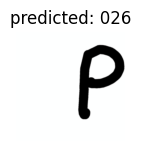

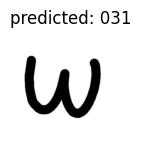

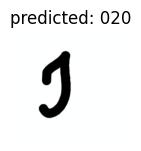

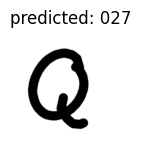

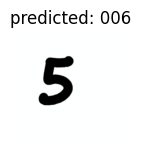

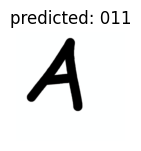

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()